- npz 파일 로딩

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = np.load('./DataFiles/cats_dogs.npz')
data

In [3]:
len(data)

4

In [4]:
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [5]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [6]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2000, 224, 224, 3), (1000, 224, 224, 3), (2000,), (1000,))

###  CNN 모델링

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [8]:
# 직접 CNN 신경망 구조를 설계하고 학습시켜보자!@
X_train[0].shape

(224, 224, 3)

In [9]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3),
                         filters = 64,
                         kernel_size = (5,5),
                         padding = 'same',
                         activation = 'relu'
                        ))
model.add(Conv2D(filters = 32,
                         kernel_size = (3,3),
                         padding = 'same',
                         activation = 'relu'
                        ))
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size=2))



# 3. MLP층에 넣어주기!
model.add(Flatten())  #input_shape는 사용하지 않아도 됨
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1238, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      18464     
_________________________________________________________________
dropout (Dropout)            (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               205521408 
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1

In [10]:
# 학습/평가 방법 설정
model.compile(loss = 'binary_crossentropy',
             optimizer = Adam(lr=0.0005),
             metrics=['acc']
             )

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 random_state = 7)

In [13]:
X_train.shape,y_train.shape

((1500, 224, 224, 3), (1500,))

In [14]:
# 1. 모델 저장
# 저장 경로 및 파일명 형태를 설정
save_path = './Cats_Dogs_Model/Cats_Dogs_Model_{epoch:03d}_{val_acc:.4f}.hdf5'
# epoch는 keras에서 지정해 놓은 키워드
# d : 10진수 형태, 03 -> 0이 3개 붙어있는 형태의 자리수(001, 002, 003 ~) 
# f : 소수점 형태, .4 -> 소수점 4자리 까지 형태의 자리수(0.001,0.002 ~)
# hdf5 : 저장되는 파일의 확장자명

f_mckp = ModelCheckpoint(filepath = save_path,  # 파일 경로 설정
                         monitor = 'val_acc',   # 해당 값을 기준으로 파일을 저장
                         save_best_only = True,# monitor 값이 가장 최고점을 갱신 했을 때 모델을 저장
                         verbose = 1 #모델 개선 및 저장 메시지를 표시
                        )

In [15]:
# 2. 조기 학습 중단
f_early = EarlyStopping(monitor = 'val_acc',
                        # monitor의 값 개선을 몇번이나 기다려줄 것인지 설정
                        patience = 5
                       )

# => 모델 학습시 val_acc가 5번의 epochs를 돌 동안 개선이 되지 않으면 중단시켜주세요!


In [16]:
h1 = model.fit(X_train, y_train,
                       validation_split=0.2,
                       epochs=100,
                       callbacks=[f_mckp, f_early]
                      )

Train on 1200 samples, validate on 300 samples
Epoch 1/100
1184/1200 [============================>.] - ETA: 0s - loss: 110.7462 - acc: 0.5372
Epoch 00001: val_acc improved from -inf to 0.50333, saving model to ./Cats_Dogs_Model/Cats_Dogs_Model_001_0.5033.hdf5
1200/1200 [==============================] - 17s 14ms/sample - loss: 109.2783 - acc: 0.5383 - val_loss: 0.6881 - val_acc: 0.5033
Epoch 2/100
1184/1200 [============================>.] - ETA: 0s - loss: 0.6391 - acc: 0.6242
Epoch 00002: val_acc improved from 0.50333 to 0.53000, saving model to ./Cats_Dogs_Model/Cats_Dogs_Model_002_0.5300.hdf5
1200/1200 [==============================] - 12s 10ms/sample - loss: 0.6375 - acc: 0.6267 - val_loss: 0.6975 - val_acc: 0.5300
Epoch 3/100
1184/1200 [============================>.] - ETA: 0s - loss: 0.4300 - acc: 0.7855
Epoch 00003: val_acc improved from 0.53000 to 0.55667, saving model to ./Cats_Dogs_Model/Cats_Dogs_Model_003_0.5567.hdf5
1200/1200 [==============================] - 12s 10ms

In [17]:
# 개, 고양이 사진의 다양함과 데이터의 규모에 비해서 Conv층과 Pooling층이 너무 간단해서 제대로 된 결과가 나오지 않음

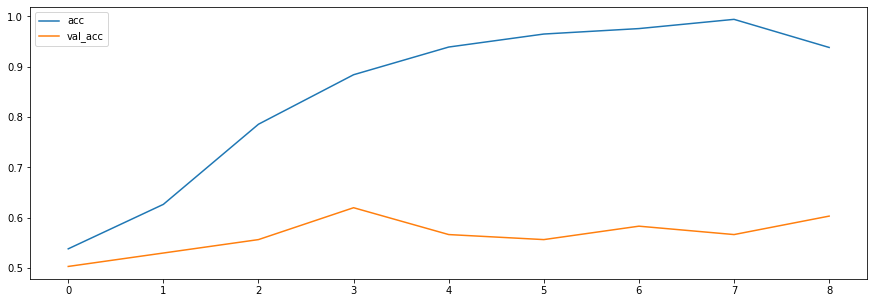

In [18]:
plt.figure(figsize=(15,5))
plt.plot(h1.history['acc'], label='acc')
plt.plot(h1.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# VGG16 모델을 개, 고양이 이미지 데이터 분류에 활용해 보자

In [38]:
from tensorflow.keras.applications import VGG16

In [39]:
vgg16 = VGG16(include_top = False,
              weights = 'imagenet',
              input_shape=(224,224,3)
             )
# include_top = False : 불러온 모델의 MLP층을 사용하지 않음(특징 추출부만 활용)

# 기존 이미지넷 대회에서는 1000가지의 이미지를 분류했으나 우리는 개, 고양이로만 분류하기 때문에 MLP층을 다르게 사용해줘야함
# weights = 'imagenet' : 이미지넷에서 학습된 가중치(w)를 그대로 가져옴.



In [40]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [41]:
# 동결시킬 층들을 확인하기 위해 VGG16모델의 layer(층) 명들을 확인
for layer in vgg16.layers : 
    print(layer.name)  # vgg16모델의 층들을 확인

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [42]:
# 신경망 설계
transfer_model = Sequential()

# 미세조정방식 적용
#---------------------------------------------------------------------------------------------------------------
# VGG16 모델에서 마지막 몇개 층들을 학습이 가능하도록 설정
# 그 외 나머지층들은 학습이 되지 않도록 동결을 시켜보자!
for layer in vgg16.layers :
    # block5_conv3,2,1 층들만 학습이 가능하도록 설정
    if layer.name == 'block5_conv3'  :
        layer.trainable = True
    else :
        layer.trainable = False # 학습이 불가능하도록 나머지 층들을 통경 시킴
#---------------------------------------------------------------------------------------------------------------        
transfer_model.add(vgg16)


transfer_model.add(Flatten())
transfer_model.add(Dense(256, activation='relu'))
transfer_model.add(Dense(128, activation='relu'))
transfer_model.add(Dense(1, activation='sigmoid'))
transfer_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total params: 21,170,497
Trainable params: 8,815,617
Non-trainable params: 12,354,880
_________________________________________________________________


In [43]:
# 학습/평가 방법 설정
transfer_model.compile(loss = 'binary_crossentropy',
             optimizer = Adam(lr=0.0005),
             metrics=['acc']
             )

In [44]:
h2 = transfer_model.fit(X_train, y_train,
                       validation_data = (X_val,y_val),
                       epochs=15
                      )

Train on 1500 samples, validate on 500 samples
Epoch 1/15
1500/1500 [==============================] - 9s 6ms/sample - loss: 1.6750 - acc: 0.9007 - val_loss: 0.3555 - val_acc: 0.9240
Epoch 2/15
1500/1500 [==============================] - 8s 6ms/sample - loss: 0.0572 - acc: 0.9853 - val_loss: 0.2650 - val_acc: 0.9600
Epoch 3/15
1500/1500 [==============================] - 8s 6ms/sample - loss: 0.0548 - acc: 0.9900 - val_loss: 0.3859 - val_acc: 0.9380
Epoch 4/15
1500/1500 [==============================] - 8s 6ms/sample - loss: 0.0098 - acc: 0.9960 - val_loss: 0.4290 - val_acc: 0.9560
Epoch 5/15
1500/1500 [==============================] - 8s 6ms/sample - loss: 0.0075 - acc: 0.9987 - val_loss: 0.2972 - val_acc: 0.9660
Epoch 6/15
1500/1500 [==============================] - 8s 6ms/sample - loss: 0.0033 - acc: 0.9980 - val_loss: 0.3592 - val_acc: 0.9560
Epoch 7/15
1500/1500 [==============================] - 8s 6ms/sample - loss: 1.3401e-04 - acc: 1.0000 - val_loss: 0.3565 - val_acc: 0.96

- 학습이 제대로 되지 않고 있음...
- MLP 층에서 발생된 오차가 역전파를 통해서 vgg16모델로 전달되면서 사전에 학습되어 있던 w,b 값들을 많이 손실 시켰음
- 사전 학습되어 있는 w,b 값이 변경되지 않도록 vgg모델의 일부층들을 동결시켜놓고 추가로 학습시켜 보기
- vgg모델의 특징 추출부에서 맨 마지막 층만 학습이 되도록 변경해보자!

### 한 번 학습이 가능하도록 설정된 층들의 경우 가중치인 w값이 다 바뀌어져 저장되어 있기 때문에 동결층을 바꿔주었다면 vgg16모델을 처음부터 import해야 함! 

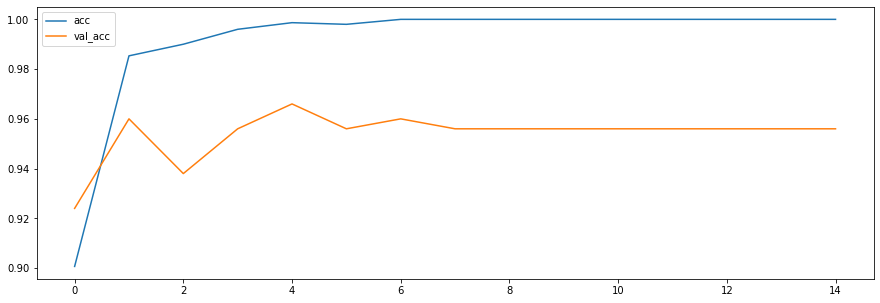

In [45]:
plt.figure(figsize=(15,5))
plt.plot(h2.history['acc'], label='acc')
plt.plot(h2.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

### 저장된 모델 로딩하기

In [25]:
from tensorflow.keras.models import load_model

In [26]:
best_model = load_model("Cats_Dogs_Model/Cats_Dogs_Model_001_0.5733.hdf5")

In [27]:
best_model.evaluate(X_test, y_test)

1000/1000 [==============================] - 1s 1ms/sample - loss: 0.6821 - acc: 0.5870


[0.6820760946273804, 0.587]

In [28]:
X_test

array([[[[139, 134, 115],
         [138, 133, 114],
         [142, 137, 118],
         ...,
         [214, 181, 138],
         [214, 181, 135],
         [215, 183, 136]],

        [[138, 133, 114],
         [138, 133, 114],
         [141, 136, 117],
         ...,
         [217, 184, 141],
         [217, 184, 139],
         [217, 185, 139]],

        [[140, 135, 116],
         [140, 135, 116],
         [136, 131, 112],
         ...,
         [218, 185, 143],
         [215, 182, 139],
         [214, 181, 137]],

        ...,

        [[189, 189, 177],
         [195, 195, 183],
         [204, 204, 192],
         ...,
         [209, 199, 189],
         [211, 201, 191],
         [204, 194, 184]],

        [[199, 199, 186],
         [203, 204, 191],
         [208, 209, 196],
         ...,
         [206, 197, 185],
         [206, 197, 185],
         [200, 190, 179]],

        [[205, 207, 192],
         [208, 209, 195],
         [210, 211, 197],
         ...,
         [204, 195, 180],
        

In [29]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [30]:
best_model.predict(X_test)

array([[0.47140244],
       [0.4770776 ],
       [0.504428  ],
       [0.46706662],
       [0.48150274],
       [0.4918244 ],
       [0.48770562],
       [0.48964202],
       [0.529498  ],
       [0.52074337],
       [0.47913098],
       [0.5101322 ],
       [0.50715107],
       [0.5046648 ],
       [0.5058928 ],
       [0.53686357],
       [0.47963703],
       [0.5015324 ],
       [0.49005383],
       [0.48065734],
       [0.48206988],
       [0.4712025 ],
       [0.51650125],
       [0.48393267],
       [0.47020733],
       [0.48136124],
       [0.49392122],
       [0.4873105 ],
       [0.47672054],
       [0.4809899 ],
       [0.46999174],
       [0.4848856 ],
       [0.5155358 ],
       [0.48094732],
       [0.48290342],
       [0.49544764],
       [0.49181136],
       [0.48508433],
       [0.5163139 ],
       [0.5284826 ],
       [0.4916378 ],
       [0.48336193],
       [0.52940917],
       [0.4937304 ],
       [0.48974976],
       [0.47912058],
       [0.477293  ],
       [0.472